In [1]:
import numpy as np
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import sys

import argparse, os, math, pickle, json

# 1) Load your model
from dual_alm_rnn_models import *
from dual_alm_rnn_models import TwoHemiRNNTanh_asymmetric_single_readout
from dual_alm_rnn_exp import DualALMRNNExp
plt.rcParams['pdf.fonttype'] = '42' 


## Large RNN analysis

In [80]:
exp = DualALMRNNExp()

# Load configs to get model parameters
with open('dual_alm_rnn_configs.json', 'r') as f:
    configs = json.load(f)

model = getattr(sys.modules[__name__], configs['model_type'])(configs, \
    exp.a, exp.pert_begin, exp.pert_end, noise=True)
# model = TwoHemiRNNTanh_single_readout(configs, exp.a, exp.pert_begin, exp.pert_end)
exp.init_sub_path(configs['train_type'])

checkpoint_file = 'model_epoch_0.pth'
checkpoint_path = os.path.join(configs['models_dir'], configs['model_type'], exp.sub_path, checkpoint_file)
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Model checkpoint not found at {checkpoint_path}")
print(checkpoint_path)
state_dict = torch.load(checkpoint_path, map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)
# params = {'batch_size': configs['bs'], 'shuffle': True}
# inputs = data.TensorDataset(torch.tensor(sensory_inputs), torch.tensor(trial_type_labels))
# inputs = data.DataLoader(inputs, **params)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # CW Mac update
model = model.to(device)
model.eval()
# Draw the readout trajectory
bias = model.readout_linear.bias.data.cpu().numpy()[0]
readout_weights = model.readout_linear.weight.data.cpu().numpy()
recurrent_weights = model.rnn_cell.w_hh_linear_ll.weight.data.cpu().numpy()
input_weights = model.w_xh_linear_left_alm.weight.data.cpu().numpy()
recurrent_bias = model.rnn_cell.w_hh_linear_ll.bias.data.cpu().numpy()

# print(model.rnn_cell.w_hh_linear_lr.weight.data.cpu().numpy())


Fixed input weights for left and right ALM
dual_alm_rnn_models/TwoHemiRNNTanh_single_readout/train_type_modular_fixed_input_cross_hemi/n_neurons_256_random_seed_2/unfix_epoch_0/n_epochs_30_n_epochs_across_hemi_0/lr_1.0e-04_bs_256/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_1.00/init_cross_hemi_rel_factor_1.00/model_epoch_0.pth


In [81]:
exp = DualALMRNNExp()


# for seed in [0,1,2,3,4,5]:
for seed in [70]:
    results_dict = np.load(
        'dual_alm_rnn_logs/{}/{}/n_neurons_256_random_seed_{}/n_epochs_30_n_epochs_across_hemi_0/lr_1.0e-04_bs_256/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'.format(
            exp.configs['model_type'],
            exp.configs['train_type'],
            seed,
            float(exp.configs['xs_left_alm_amp']),
            float(exp.configs['xs_right_alm_amp'])
        ),
        allow_pickle=True
    )
    epochs = np.arange(1, len(results_dict) + 1)
    readout_acc_left = np.array([results_dict[i]['control']['readout_accuracy_left'] for i in range(len(results_dict))])
    readout_acc_right = np.array([results_dict[i]['control']['readout_accuracy_right'] for i in range(len(results_dict))])

    n_trials_agreed = np.array([results_dict[i]['control']['n_trials_agreed'] for i in range(len(results_dict))])
    n_trials = np.array([results_dict[i]['control']['n_trials'] for i in range(len(results_dict))])
    agreement_frac = n_trials_agreed / n_trials

    # Compute chance level: p(agree) = p_L^2 + (1-p_L)^2 if p_L = p_R, but here use both
    chance_agree = readout_acc_left * readout_acc_right + (1 - readout_acc_left) * (1 - readout_acc_right)

    corruption_start_epoch = exp.configs['corruption_start_epoch']

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # Top subplot: Readout accuracies
    ax1.plot(epochs, readout_acc_left, color='r', label='Left Hemi Readout Accuracy')
    ax1.plot(epochs, readout_acc_right, color='b', label='Right Hemi Readout Accuracy')
    if exp.configs['train_type'] == 'train_type_modular_corruption':
        ax1.axvline(corruption_start_epoch, color='r', linestyle=':', linewidth=2, label='Corruption Start (Epoch {})'.format(corruption_start_epoch))
    ax1.set_ylabel('Readout Accuracy (Control)')
    ax1.set_title('Readout Accuracy Over Training (Control Trials)')
    ax1.set_xticks(epochs)
    ax1.set_ylim(0.4, 1.05)
    ax1.legend()

    # Bottom subplot: Agreement
    ax2.plot(epochs, agreement_frac, color='k', label='Empirical Agreement (L=R)')
    ax2.plot(epochs, chance_agree, color='gray', linestyle='--', label='Chance Level (Binomial)')
    if exp.configs['train_type'] == 'train_type_modular_corruption':
        ax2.axvline(corruption_start_epoch, color='r', linestyle=':', linewidth=2, label='Corruption Start (Epoch {})'.format(corruption_start_epoch))
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Fraction of Trials with L=R')
    ax2.set_title('Left/Right ALM Agreement Over Training (Control Trials)')
    ax2.set_xticks(epochs)
    ax2.set_ylim(0.4, 1.05)
    ax2.legend()

    plt.tight_layout()
    plt.show()
# if exp.configs['train_type'] == 'train_type_modular_corruption':
#     plt.savefig('figs/LR_readoutacc_and_agreement_learning_{}_L{}_R{}_epoch_{}_noise_{}0_type_{}.pdf'.format(exp.configs['train_type'], 
#                                                                                                             exp.configs['xs_left_alm_amp'], 
#                                                                                                             exp.configs['xs_right_alm_amp'], 
#                                                                                                             exp.configs['corruption_start_epoch'], 
#                                                                                                             exp.configs['corruption_noise'], 
#                                                                                                             exp.configs['corruption_type']))
# elif 'asymmetric_fix' in exp.configs['train_type']:
#     plt.savefig('figs/LR_readoutacc_and_agreement_learning_{}_L{}_R{}_unfix_epoch_{}_type_{}.pdf'.format(exp.configs['train_type'], 
#                                                                                             exp.configs['xs_left_alm_amp'], 
#                                                                                             exp.configs['xs_right_alm_amp'], 
#                                                                                             exp.configs['unfix_epoch'],
#                                                                                             exp.configs['train_type']))
# else:
#     plt.savefig('figs/LR_readoutacc_and_agreement_learning_{}_L{}_R{}_type_{}.pdf'.format(exp.configs['train_type'], 
#                                                                                             exp.configs['xs_left_alm_amp'], 
#                                                                                             exp.configs['xs_right_alm_amp'], 
#                                                                                             exp.configs['train_type']))
# plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'dual_alm_rnn_logs/TwoHemiRNNTanh_single_readout/train_type_modular_fixed_input_cross_hemi/n_neurons_256_random_seed_70/n_epochs_30_n_epochs_across_hemi_0/lr_1.0e-04_bs_256/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_1.00/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'

### Add pre-learned hemi to left side

Fixed input weights for left and right ALM
dual_alm_rnn_models/TwoHemiRNNTanh_single_readout/train_type_modular_asymmetric_fixed_input/n_neurons_128_random_seed_2/unfix_epoch_10/n_epochs_30_n_epochs_across_hemi_0/lr_1.0e-04_bs_256/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_1.00/init_cross_hemi_rel_factor_0.20/model_epoch_8.pth
0.0006300261302385479 3.054283771896735
0.0 49.70044
2.0 128.0


array([0.536, 0.546, 0.546, 0.556, 0.54 , 0.528, 0.532, 0.534, 0.542,
       0.542, 0.542, 0.532, 0.526, 0.53 , 0.524, 0.514, 0.514, 0.514,
       0.506, 0.512, 0.524, 0.592, 0.842, 0.998, 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   ])

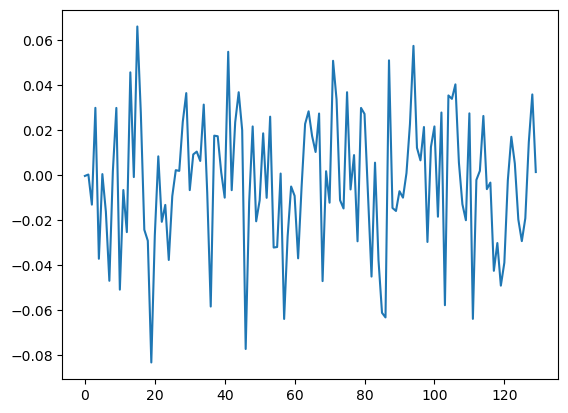

In [61]:
exp = DualALMRNNExp()

# Load configs to get model parameters
with open('dual_alm_rnn_configs.json', 'r') as f:
    configs = json.load(f)

model = TwoHemiRNNTanh_asymmetric_single_readout(configs, \
    exp.a, exp.pert_begin, exp.pert_end, noise=True)
# model = TwoHemiRNNTanh_single_readout(configs, exp.a, exp.pert_begin, exp.pert_end)
exp.init_sub_path(configs['train_type'])

checkpoint_file = 'model_epoch_8.pth'
checkpoint_path = os.path.join(configs['models_dir'], configs['model_type'], exp.sub_path, checkpoint_file)
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Model checkpoint not found at {checkpoint_path}")
print(checkpoint_path)
state_dict = torch.load(checkpoint_path, map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)
# params = {'batch_size': configs['bs'], 'shuffle': True}
# inputs = data.TensorDataset(torch.tensor(sensory_inputs), torch.tensor(trial_type_labels))
# inputs = data.DataLoader(inputs, **params)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # CW Mac update
model = model.to(device)
model.eval()
# Draw the readout trajectory
bias = model.readout_linear.bias.data.cpu().numpy()[0]
readout_weights = model.readout_linear.weight.data.cpu().numpy()
recurrent_weights = model.rnn_cell.w_hh_linear_ll.weight.data.cpu().numpy()
recurrent_weights_r = model.rnn_cell.w_hh_linear_rr.weight.data.cpu().numpy()
input_weights = model.w_xh_linear_left_alm.weight.data.cpu().numpy()
input_weights_r = model.w_xh_linear_right_alm.weight.data.cpu().numpy()
recurrent_bias = model.rnn_cell.w_hh_linear_ll.bias.data.cpu().numpy()

plt.plot(readout_weights.flatten())
print(sum(np.abs(readout_weights.flatten()[:2])), sum(np.abs(readout_weights.flatten()[2:])))
print(np.sum(np.abs(recurrent_weights)), np.sum(np.abs(recurrent_weights_r)))
print(np.sum(np.abs(input_weights)), np.sum(np.abs(input_weights_r)))
# print(model.rnn_cell.w_hh_linear_lr.weight.data.cpu().numpy())
readout_acc_right

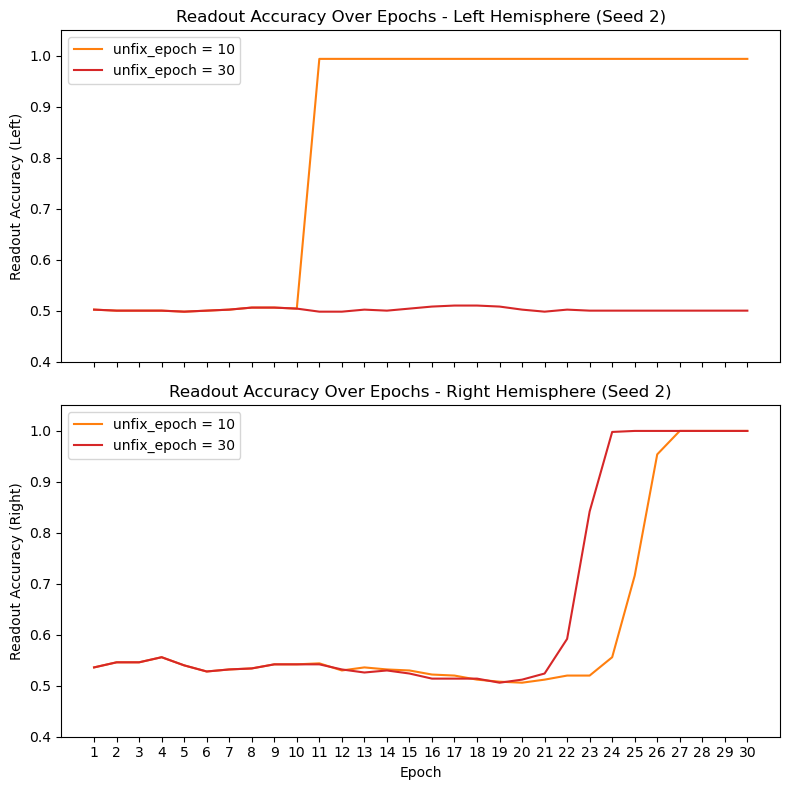

In [60]:
# Plot both unfix_epoch=0 and unfix_epoch=10 for this seed
seed = 2

fig, (ax_left, ax_right) = plt.subplots(2, 1, figsize=(8,8), sharex=True)

unfix_epochs_to_compare = [10,30]
colors = {1: 'tab:blue', 10: 'tab:orange', 20: 'tab:green', 30: 'tab:red', 40: 'tab:purple'}
labels = {1: 'unfix_epoch = 1', 10: 'unfix_epoch = 10', 20: 'unfix_epoch = 20', 30: 'unfix_epoch = 30', 40: 'unfix_epoch = 40'}
readout_accs_left = {}
readout_accs_right = {}
epochs_dict = {}

for unfix_epoch in unfix_epochs_to_compare:
    # Load results_dict for each unfix_epoch
    results_dict = np.load(
        'dual_alm_rnn_logs/{}/{}/n_neurons_128_random_seed_{}/unfix_epoch_{}/n_epochs_30_n_epochs_across_hemi_0/lr_1.0e-04_bs_256/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'.format(
            exp.configs['model_type'],
            exp.configs['train_type'],
            seed,
            unfix_epoch,
            float(exp.configs['xs_left_alm_amp']),
            float(exp.configs['xs_right_alm_amp'])
        ),
        allow_pickle=True
    )
    epochs = np.arange(1, len(results_dict)+1)
    readout_acc_left = np.array([results_dict[i]['control']['readout_accuracy_left'] for i in range(len(results_dict))])
    readout_acc_right = np.array([results_dict[i]['control']['readout_accuracy_right'] for i in range(len(results_dict))])
    readout_accs_left[unfix_epoch] = readout_acc_left
    readout_accs_right[unfix_epoch] = readout_acc_right
    epochs_dict[unfix_epoch] = epochs

    # Plot for left accuracy
    ax_left.plot(epochs, readout_acc_left, color=colors[unfix_epoch], label=labels[unfix_epoch])
    # Plot for right accuracy
    ax_right.plot(epochs, readout_acc_right, color=colors[unfix_epoch], label=labels[unfix_epoch])

ax_left.set_ylabel('Readout Accuracy (Left)')
ax_left.set_title(f'Readout Accuracy Over Epochs - Left Hemisphere (Seed {seed})')
ax_left.set_xticks(epochs)
ax_left.set_ylim(0.4, 1.05)
ax_left.legend()

ax_right.set_ylabel('Readout Accuracy (Right)')
ax_right.set_xlabel('Epoch')
ax_right.set_title(f'Readout Accuracy Over Epochs - Right Hemisphere (Seed {seed})')
ax_right.set_xticks(epochs)
ax_right.set_ylim(0.4, 1.05)
ax_right.legend()

plt.tight_layout()
plt.show()


In [45]:
add_epoch_1.shape

(100, 30)

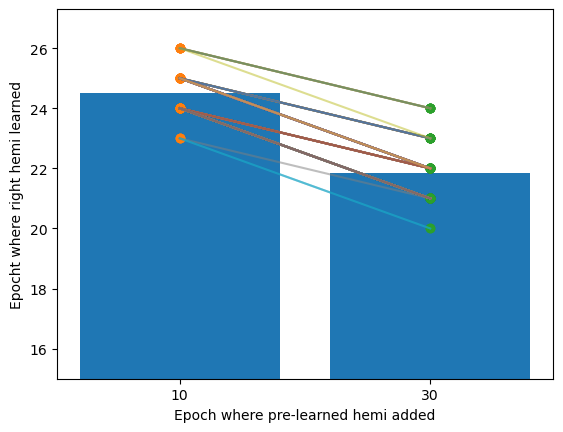

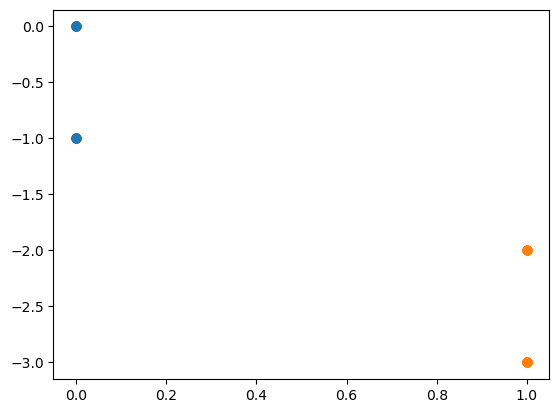

In [67]:
add_epoch_1 = np.load('test/results/largernn_prelearned/epoch_1/all_readout_acc_right.npy')
add_epoch_10 = np.load('test/results/largernn_prelearned/epoch_10/all_readout_acc_right.npy')
add_epoch_20 = np.load('test/results/largernn_prelearned/epoch_20/all_readout_acc_right.npy')
add_epoch_30 = np.load('test/results/largernn_prelearned/epoch_30/all_readout_acc_right.npy')

learned_epoch_1 = [np.where(e > 0.7)[0][0] for e in add_epoch_1]
learned_epoch_10 = [np.where(e > 0.7)[0][0] for e in add_epoch_10]
learned_epoch_20 = [np.where(e > 0.7)[0][0] for e in add_epoch_20]
learned_epoch_30 = [np.where(e > 0.7)[0][0] for e in add_epoch_30]

diff_1 = np.array(learned_epoch_30) - np.array(learned_epoch_1)
diff_10 = np.array(learned_epoch_30) - np.array(learned_epoch_10)


plt.bar([0,1], [np.mean(learned_epoch_10), np.mean(learned_epoch_30)])
plt.scatter(np.zeros(len(learned_epoch_10)), learned_epoch_10)
plt.scatter(np.ones(len(learned_epoch_30)), learned_epoch_30)
for i in range(100):
    plt.plot([0,1], [learned_epoch_10[i], learned_epoch_30[i]], alpha=0.5)
plt.ylim(15)
plt.ylabel('Epocht where right hemi learned')
plt.xticks([0,1],['10', '30'])
plt.xlabel('Epoch where pre-learned hemi added')

plt.show()

plt.scatter(np.zeros(100), diff_1)
plt.scatter(np.ones(100), diff_10)


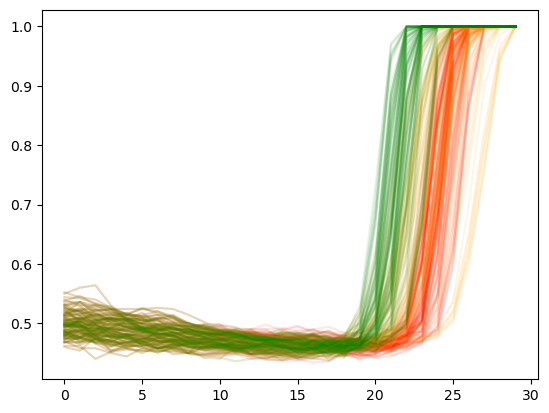

In [47]:
add_epoch_1 = np.load('test/results/largernn_prelearned/epoch_1/all_readout_acc_right.npy')
add_epoch_10 = np.load('test/results/largernn_prelearned/epoch_10/all_readout_acc_right.npy')
add_epoch_20 = np.load('test/results/largernn_prelearned/epoch_20/all_readout_acc_right.npy')
add_epoch_30 = np.load('test/results/largernn_prelearned/epoch_30/all_readout_acc_right.npy')

# plt.plot(add_epoch_1.T, color='red',alpha=0.1)
plt.plot(add_epoch_10.T, color='red',alpha=0.1)
plt.plot(add_epoch_20.T, color='orange',alpha=0.1)
plt.plot(add_epoch_30.T, color='green',alpha=0.1)
# plt.plot(add_epoch_10.T, color='r')



## Cross hemi weights

In [72]:
exp.sub_path

'train_type_modular_asymmetric_fixed_input/n_neurons_128_random_seed_2/unfix_epoch_10/n_epochs_30_n_epochs_across_hemi_0/lr_1.0e-04_bs_256/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_1.00/init_cross_hemi_rel_factor_0.20'

In [81]:
exp = DualALMRNNExp()

# Load configs to get model parameters
with open('dual_alm_rnn_configs.json', 'r') as f:
    configs = json.load(f)

    # "train_type":"train_type_modular_fixed_input_cross_hemi_switch",
exp.configs['train_type'] ="train_type_modular_fixed_input_cross_hemi"
exp.configs['init_cross_hemi_rel_factor'] = 0.2
exp.configs['random_seed'] = 2
exp.configs['n_epochs'] = 30

model = getattr(sys.modules[__name__], exp.configs['model_type'])(configs, \
    exp.a, exp.pert_begin, exp.pert_end, noise=True)
# model = TwoHemiRNNTanh_single_readout(configs, exp.a, exp.pert_begin, exp.pert_end)
exp.init_sub_path(exp.configs['train_type'])

checkpoint_file = 'last_model.pth'
# checkpoint_file = 'model_epoch_15.pth'
checkpoint_path = os.path.join(exp.configs['models_dir'], exp.configs['model_type'], exp.sub_path, checkpoint_file)
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Model checkpoint not found at {checkpoint_path}")
print(checkpoint_path)
state_dict = torch.load(checkpoint_path, map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)
# params = {'batch_size': configs['bs'], 'shuffle': True}
# inputs = data.TensorDataset(torch.tensor(sensory_inputs), torch.tensor(trial_type_labels))
# inputs = data.DataLoader(inputs, **params)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # CW Mac update
model = model.to(device)
model.eval()
# Draw the readout trajectory
bias = model.readout_linear.bias.data.cpu().numpy()[0]
readout_weights = model.readout_linear.weight.data.cpu().numpy()
recurrent_weights = model.rnn_cell.w_hh_linear_ll.weight.data.cpu().numpy()
input_weights = model.w_xh_linear_left_alm.weight.data.cpu().numpy()
recurrent_bias = model.rnn_cell.w_hh_linear_ll.bias.data.cpu().numpy()

# print(input_weights)
# plt.plot(model.rnn_cell.w_hh_linear_lr.weight.data.cpu().numpy())
# plt.plot(model.rnn_cell.w_hh_linear_rl.weight.data.cpu().numpy())
# plt.plot(model.rnn_cell.w_hh_linear_rr.weight.data.cpu().numpy())
# plt.plot(model.rnn_cell.w_hh_linear_ll.weight.data.cpu().numpy())
print(np.sum(np.abs(model.rnn_cell.w_hh_linear_rr.weight.data.cpu().numpy())), np.sum(np.abs(model.rnn_cell.w_hh_linear_ll.weight.data.cpu().numpy())))
model.rnn_cell.w_hh_linear_rl.weight.data.cpu().numpy()

Fixed input weights for left and right ALM
dual_alm_rnn_models/TwoHemiRNNTanh_single_readout/train_type_modular_fixed_input_cross_hemi/n_neurons_256_random_seed_2/unfix_epoch_0/n_epochs_30_n_epochs_across_hemi_0/lr_1.0e-04_bs_256/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_1.00/init_cross_hemi_rel_factor_0.20/last_model.pth
817.36816 823.32935


array([[-0.01500921, -0.02227066,  0.01372786, ..., -0.00766666,
         0.00782884, -0.01002589],
       [ 0.01463437, -0.0039865 , -0.00946482, ..., -0.00742631,
        -0.01223025,  0.00275379],
       [ 0.01516731,  0.00704942,  0.00334502, ..., -0.00169075,
        -0.00767088, -0.00863272],
       ...,
       [-0.00165826, -0.006579  , -0.02302705, ...,  0.01750646,
         0.00262603, -0.01267189],
       [-0.01577165,  0.00579363,  0.00230097, ...,  0.0209586 ,
         0.00712681, -0.01758255],
       [-0.02867972, -0.00449174,  0.00293706, ..., -0.00452219,
         0.01030753,  0.01406955]], dtype=float32)

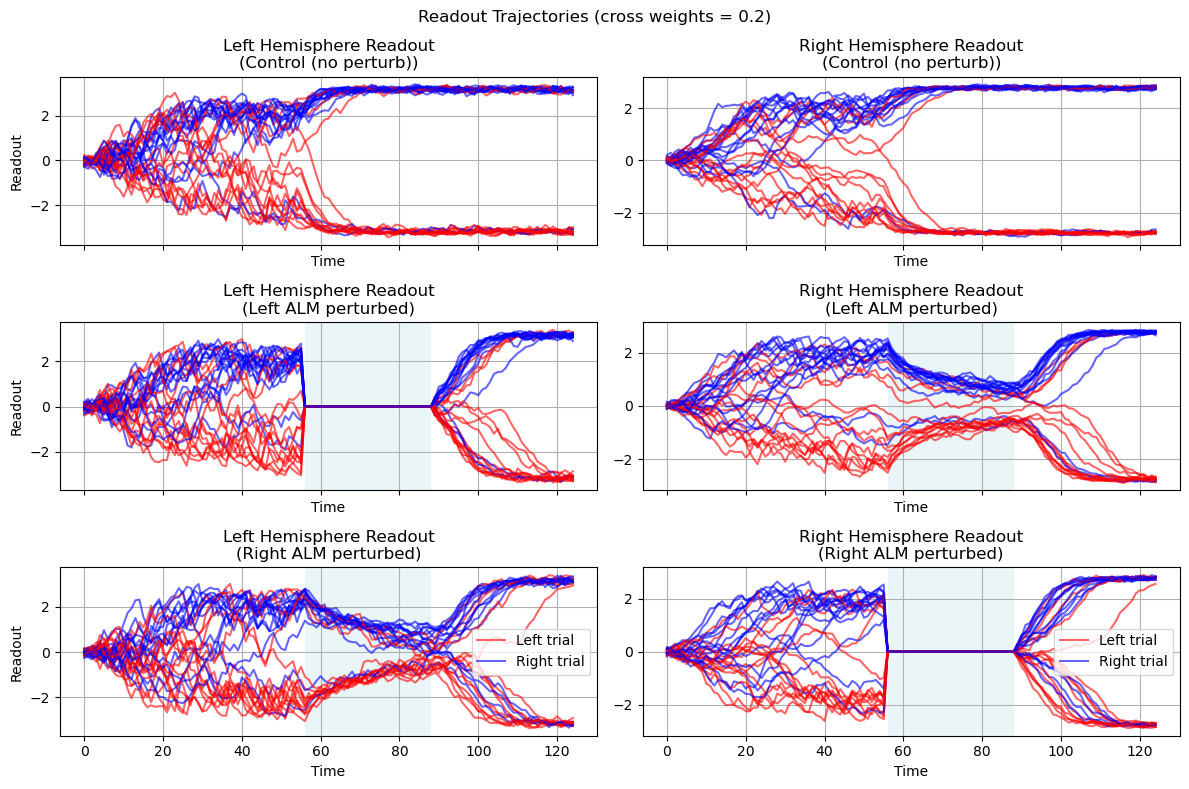

In [84]:
# Plot what happens to individual readouts on control vs perturbation trials
import matplotlib.gridspec as gridspec

# start by loading data
train_save_path = os.path.join(exp.configs['data_dir'], 'train')

train_sensory_inputs = np.load(os.path.join(train_save_path, 'onehot_sensory_inputs.npy' ))
train_trial_type_labels = np.load(os.path.join(train_save_path, 'onehot_trial_type_labels.npy'))
# load train inputs and labels

train_sensory_inputs.shape, train_trial_type_labels.shape

l_trial_idx = np.where(train_trial_type_labels == 0)[0]
r_trial_idx = np.where(train_trial_type_labels == 1)[0]

l_trial_input = train_sensory_inputs[l_trial_idx, :]
r_trial_input = train_sensory_inputs[r_trial_idx, :]

l_trial_input = torch.tensor(l_trial_input).to(device)
r_trial_input = torch.tensor(r_trial_input).to(device)
l_trial_input.shape

sample_begin = exp.sample_begin
delay_begin = exp.delay_begin
l_trial_input_all, r_trial_input_all = l_trial_input, r_trial_input


### After data loading, run model

# Pass input into model
fig, axs = plt.subplots(3, 2, figsize=(12, 8), sharex=True)  # 3 conditions, 2 hemispheres

# Define condition names for labeling
condition_names = [
    "Control (no perturb)", 
    "Left ALM perturbed", 
    "Right ALM perturbed"
]
# For legend management
line_objs = [[None, None] for _ in range(3)]

# For each of the three conditions: control, left alm pert, right alm pert
for rowidx, (uni_pert, left_pert) in enumerate([
        (0.0, 0.5),   # Control: no perturb
        (1.0, 1.0),   # Left ALM perturbed
        (1.0, 0.0)    # Right ALM perturbed
    ]):

    # Set model perturbation parameters for condition
    model.uni_pert_trials_prob = uni_pert
    model.left_alm_pert_prob = left_pert
    hs_l, zs_l = model(l_trial_input_all)    # left trial
    hs_r, zs_r = model(r_trial_input_all)    # right trial

    for i in range(15):
        # l_trial_input = l_trial_input_all[i].reshape(1, exp.T, 2)
        # r_trial_input = r_trial_input_all[i].reshape(1, exp.T, 2)

        # Compute left and right readouts for left and right trials
        left_readout_l = hs_l[i, :, :model.n_neurons//2].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, :model.n_neurons//2]
        )
        right_readout_l = hs_l[i, :, model.n_neurons//2:].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, model.n_neurons//2:]
        )

        left_readout_r = hs_r[i, :, :model.n_neurons//2].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, :model.n_neurons//2]
        )
        right_readout_r = hs_r[i, :, model.n_neurons//2:].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, model.n_neurons//2:]
        )

        # Left hemisphere readout subplot (col 0)
        l_line = axs[rowidx,0].plot(left_readout_l.flatten(), color='red', alpha=0.6, label='Left trial' if i==0 else None)
        r_line = axs[rowidx,0].plot(left_readout_r.flatten(), color='blue', alpha=0.6, label='Right trial' if i==0 else None)
        if i == 0: line_objs[rowidx][0] = (l_line[0], r_line[0])

        # Right hemisphere readout subplot (col 1)
        l_line2 = axs[rowidx,1].plot(right_readout_l.flatten(), color='red', alpha=0.6, label='Left trial' if i==0 else None)
        r_line2 = axs[rowidx,1].plot(right_readout_r.flatten(), color='blue', alpha=0.6, label='Right trial' if i==0 else None)
        if i == 0: line_objs[rowidx][1] = (l_line2[0], r_line2[0])

    # Add light blue bar (span) for perturbation period on perturbation subplots
    # Only add for perturbed conditions (rowidx 1 and 2)
    if rowidx in [1, 2]:
        # perturbation likely in delay epoch; use exp.delay_begin, exp.T for x-range
        axs[rowidx,0].axvspan(exp.delay_begin, exp.pert_end, facecolor='lightblue', alpha=0.25, zorder=0)
        axs[rowidx,1].axvspan(exp.delay_begin, exp.pert_end, facecolor='lightblue', alpha=0.25, zorder=0)

    # Titles, labels for each row
    axs[rowidx,0].set_title(f"Left Hemisphere Readout\n({condition_names[rowidx]})" )
    axs[rowidx,1].set_title(f"Right Hemisphere Readout\n({condition_names[rowidx]})")
    axs[rowidx,0].set_ylabel("Readout")
    axs[rowidx,0].set_xlabel("Time")
    axs[rowidx,1].set_xlabel("Time")
    axs[rowidx,0].grid()
    axs[rowidx,1].grid()

# Only show legend in the bottom row for both hemispheres (col 0/col 1)
for col in range(2):
    axs[-1,col].legend()

plt.suptitle(f'Readout Trajectories (cross weights = {exp.configs["init_cross_hemi_rel_factor"]})')
plt.tight_layout()
plt.show()




In [ ]:
exp = DualALMRNNExp()


# for seed in [0,1,2,3,4,5]:
for seed in [70]:
    results_dict = np.load(
        'dual_alm_rnn_logs/{}/{}/n_neurons_256_random_seed_{}/n_epochs_30_n_epochs_across_hemi_0/lr_1.0e-04_bs_256/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'.format(
            exp.configs['model_type'],
            exp.configs['train_type'],
            seed,
            float(exp.configs['xs_left_alm_amp']),
            float(exp.configs['xs_right_alm_amp'])
        ),
        allow_pickle=True
    )
    epochs = np.arange(1, len(results_dict) + 1)
    readout_acc_left = np.array([results_dict[i]['control']['readout_accuracy_left'] for i in range(len(results_dict))])
    readout_acc_right = np.array([results_dict[i]['control']['readout_accuracy_right'] for i in range(len(results_dict))])

    n_trials_agreed = np.array([results_dict[i]['control']['n_trials_agreed'] for i in range(len(results_dict))])
    n_trials = np.array([results_dict[i]['control']['n_trials'] for i in range(len(results_dict))])
    agreement_frac = n_trials_agreed / n_trials

    # Compute chance level: p(agree) = p_L^2 + (1-p_L)^2 if p_L = p_R, but here use both
    chance_agree = readout_acc_left * readout_acc_right + (1 - readout_acc_left) * (1 - readout_acc_right)

    corruption_start_epoch = exp.configs['corruption_start_epoch']

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # Top subplot: Readout accuracies
    ax1.plot(epochs, readout_acc_left, color='r', label='Left Hemi Readout Accuracy')
    ax1.plot(epochs, readout_acc_right, color='b', label='Right Hemi Readout Accuracy')
    if exp.configs['train_type'] == 'train_type_modular_corruption':
        ax1.axvline(corruption_start_epoch, color='r', linestyle=':', linewidth=2, label='Corruption Start (Epoch {})'.format(corruption_start_epoch))
    ax1.set_ylabel('Readout Accuracy (Control)')
    ax1.set_title('Readout Accuracy Over Training (Control Trials)')
    ax1.set_xticks(epochs)
    ax1.set_ylim(0.4, 1.05)
    ax1.legend()

    # Bottom subplot: Agreement
    ax2.plot(epochs, agreement_frac, color='k', label='Empirical Agreement (L=R)')
    ax2.plot(epochs, chance_agree, color='gray', linestyle='--', label='Chance Level (Binomial)')
    if exp.configs['train_type'] == 'train_type_modular_corruption':
        ax2.axvline(corruption_start_epoch, color='r', linestyle=':', linewidth=2, label='Corruption Start (Epoch {})'.format(corruption_start_epoch))
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Fraction of Trials with L=R')
    ax2.set_title('Left/Right ALM Agreement Over Training (Control Trials)')
    ax2.set_xticks(epochs)
    ax2.set_ylim(0.4, 1.05)
    ax2.legend()

    plt.tight_layout()
    plt.show()
# if exp.configs['train_type'] == 'train_type_modular_corruption':
#     plt.savefig('figs/LR_readoutacc_and_agreement_learning_{}_L{}_R{}_epoch_{}_noise_{}0_type_{}.pdf'.format(exp.configs['train_type'], 
#                                                                                                             exp.configs['xs_left_alm_amp'], 
#                                                                                                             exp.configs['xs_right_alm_amp'], 
#                                                                                                             exp.configs['corruption_start_epoch'], 
#                                                                                                             exp.configs['corruption_noise'], 
#                                                                                                             exp.configs['corruption_type']))
# elif 'asymmetric_fix' in exp.configs['train_type']:
#     plt.savefig('figs/LR_readoutacc_and_agreement_learning_{}_L{}_R{}_unfix_epoch_{}_type_{}.pdf'.format(exp.configs['train_type'], 
#                                                                                             exp.configs['xs_left_alm_amp'], 
#                                                                                             exp.configs['xs_right_alm_amp'], 
#                                                                                             exp.configs['unfix_epoch'],
#                                                                                             exp.configs['train_type']))
# else:
#     plt.savefig('figs/LR_readoutacc_and_agreement_learning_{}_L{}_R{}_type_{}.pdf'.format(exp.configs['train_type'], 
#                                                                                             exp.configs['xs_left_alm_amp'], 
#                                                                                             exp.configs['xs_right_alm_amp'], 
#                                                                                             exp.configs['train_type']))
# plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'dual_alm_rnn_logs/TwoHemiRNNTanh_single_readout/train_type_modular_fixed_input_cross_hemi/n_neurons_256_random_seed_70/n_epochs_30_n_epochs_across_hemi_0/lr_1.0e-04_bs_256/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_1.00/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'

### Plot accuracy over learning

Fixed input weights for left and right ALM


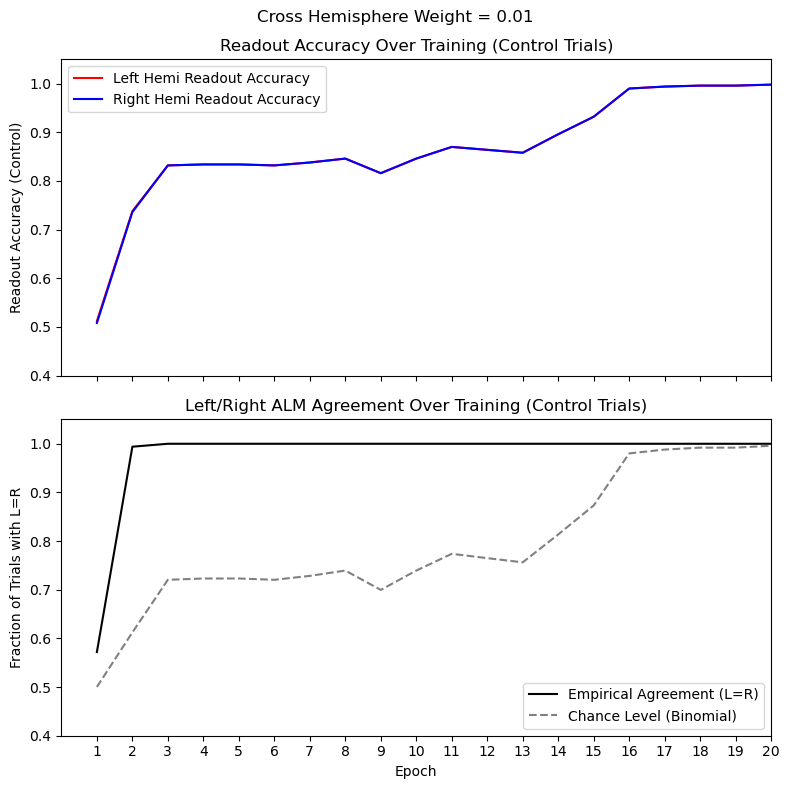

Fixed input weights for left and right ALM


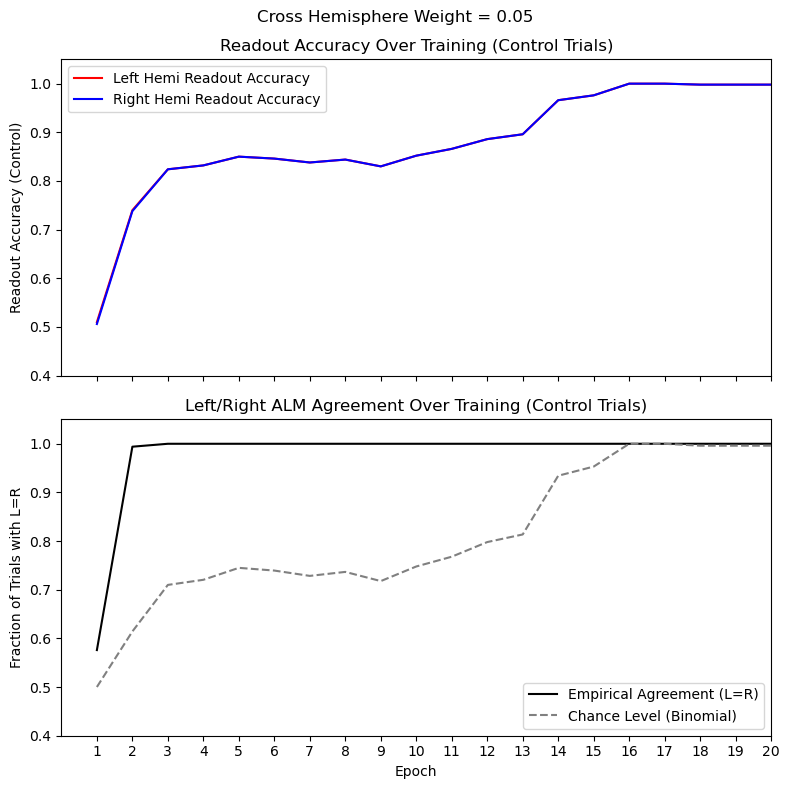

Fixed input weights for left and right ALM


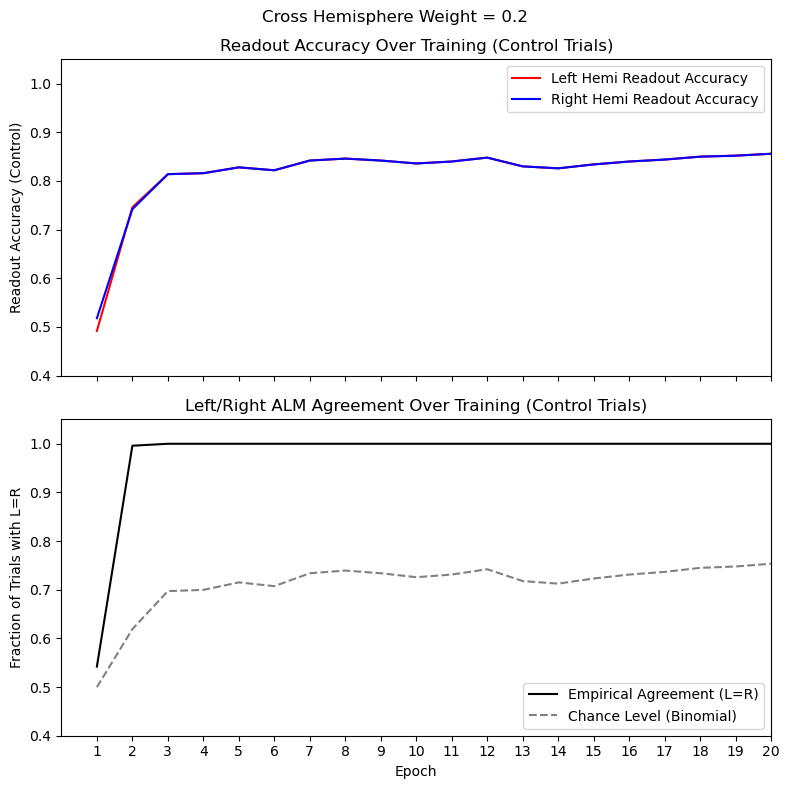

Fixed input weights for left and right ALM


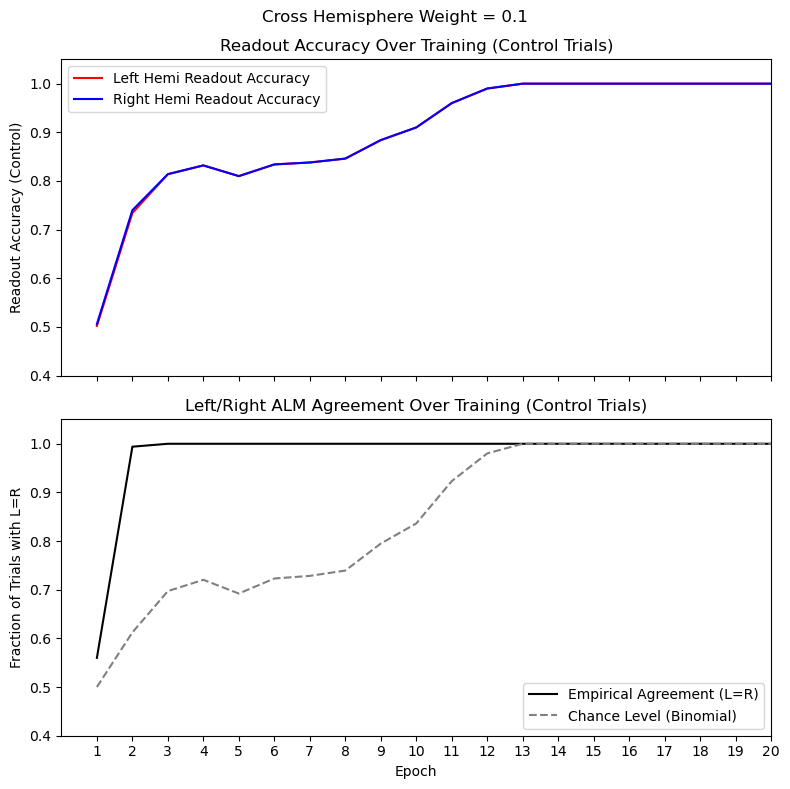

Fixed input weights for left and right ALM


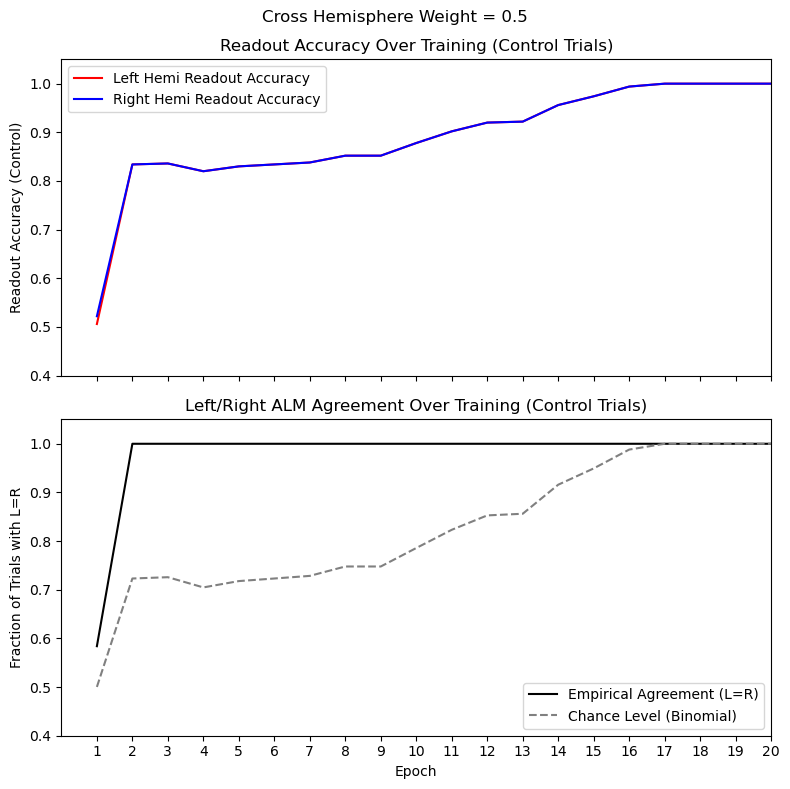

Fixed input weights for left and right ALM


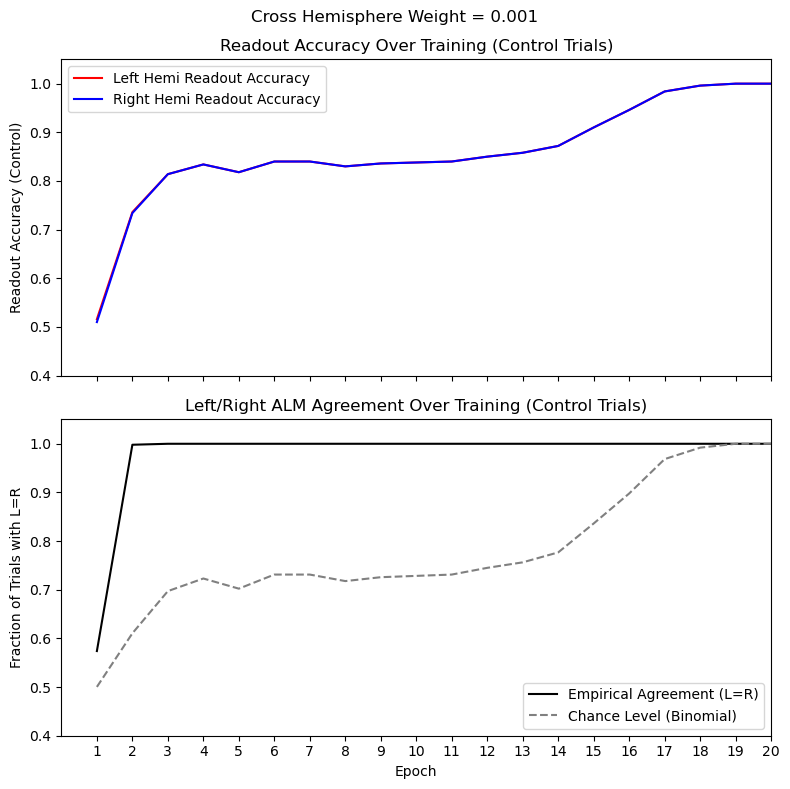

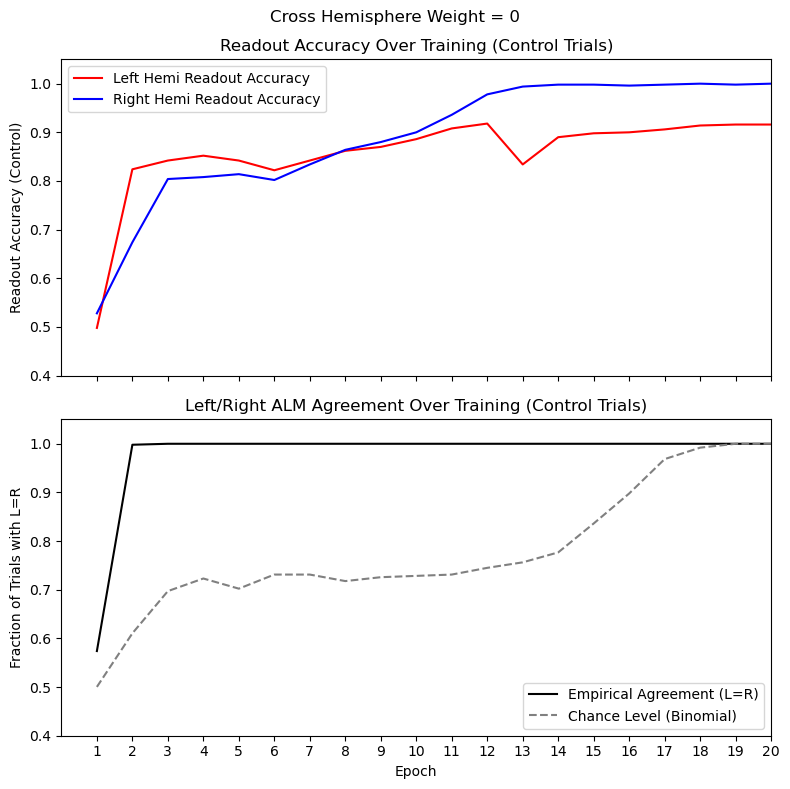

In [254]:
# cross_hemi=0.2
time_to_reach = []
time_to_reach_right = []
for cross_hemi in [0.01, 0.05, 0.2,0.1, 0.5, 0.001]:


    exp = DualALMRNNExp()

    # Load configs to get model parameters
    with open('dual_alm_rnn_configs.json', 'r') as f:
        configs = json.load(f)

    exp.configs['init_cross_hemi_rel_factor'] = cross_hemi
    exp.configs['random_seed'] = 0
    exp.configs['n_epochs'] = 20
    exp.configs['train_type'] = 'train_type_modular_fixed_input_cross_hemi'

    

    model = getattr(sys.modules[__name__], configs['model_type'])(configs, \
        exp.a, exp.pert_begin, exp.pert_end, noise=True)

    exp.init_sub_path(exp.configs['train_type'])
    checkpoint_file = 'all_val_results_dict.npy'
    checkpoint_path = os.path.join(configs['logs_dir'], configs['model_type'], exp.sub_path, checkpoint_file)

    results_dict = np.load(checkpoint_path, allow_pickle=True)

    epochs = np.arange(1, len(results_dict) + 1)
    readout_acc_left = np.array([results_dict[i]['control']['readout_accuracy_left'] for i in range(len(results_dict))])
    readout_acc_right = np.array([results_dict[i]['control']['readout_accuracy_right'] for i in range(len(results_dict))])

    # time_to_reach.append(np.where(readout_acc_left > 0.9)[0][0])
    # time_to_reach_right.append(np.where(readout_acc_right > 0.9)[0][0])


    n_trials_agreed = np.array([results_dict[i]['control']['n_trials_agreed'] for i in range(len(results_dict))])
    n_trials = np.array([results_dict[i]['control']['n_trials'] for i in range(len(results_dict))])
    agreement_frac = n_trials_agreed / n_trials

    # Compute chance level: p(agree) = p_L^2 + (1-p_L)^2 if p_L = p_R, but here use both
    chance_agree = readout_acc_left * readout_acc_right + (1 - readout_acc_left) * (1 - readout_acc_right)

    corruption_start_epoch = exp.configs['corruption_start_epoch']

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # Top subplot: Readout accuracies
    ax1.plot(epochs, readout_acc_left, color='r', label='Left Hemi Readout Accuracy')
    ax1.plot(epochs, readout_acc_right, color='b', label='Right Hemi Readout Accuracy')
    if exp.configs['train_type'] == 'train_type_modular_corruption':
        ax1.axvline(corruption_start_epoch, color='r', linestyle=':', linewidth=2, label='Corruption Start (Epoch {})'.format(corruption_start_epoch))
    ax1.set_ylabel('Readout Accuracy (Control)')
    ax1.set_title('Readout Accuracy Over Training (Control Trials)')
    ax1.set_xticks(epochs)
    ax1.set_ylim(0.4, 1.05)
    ax1.legend()

    # Bottom subplot: Agreement
    ax2.plot(epochs, agreement_frac, color='k', label='Empirical Agreement (L=R)')
    ax2.plot(epochs, chance_agree, color='gray', linestyle='--', label='Chance Level (Binomial)')
    if exp.configs['train_type'] == 'train_type_modular_corruption':
        ax2.axvline(corruption_start_epoch, color='r', linestyle=':', linewidth=2, label='Corruption Start (Epoch {})'.format(corruption_start_epoch))
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Fraction of Trials with L=R')
    ax2.set_title('Left/Right ALM Agreement Over Training (Control Trials)')
    ax2.set_xticks(epochs)
    ax2.set_ylim(0.4, 1.05)
    ax2.legend()
    plt.xlim(0,20)

    plt.suptitle(f'Cross Hemisphere Weight = {cross_hemi}')

    plt.tight_layout()
    plt.show()

exp = DualALMRNNExp()

# Load configs to get model parameters
with open('dual_alm_rnn_configs.json', 'r') as f:
    configs = json.load(f)
    
exp.configs['train_type'] = 'train_type_modular_fixed_input'
exp.configs['init_cross_hemi_rel_factor'] = 0.2
exp.configs['random_seed'] = 2
exp.init_sub_path(exp.configs['train_type'])

checkpoint_file = 'all_val_results_dict.npy'
checkpoint_path = os.path.join(configs['logs_dir'], configs['model_type'], exp.sub_path, checkpoint_file)

results_dict = np.load(checkpoint_path, allow_pickle=True)

epochs = np.arange(1, len(results_dict) + 1)
readout_acc_left = np.array([results_dict[i]['control']['readout_accuracy_left'] for i in range(len(results_dict))])
readout_acc_right = np.array([results_dict[i]['control']['readout_accuracy_right'] for i in range(len(results_dict))])


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Top subplot: Readout accuracies
ax1.plot(epochs, readout_acc_left, color='r', label='Left Hemi Readout Accuracy')
ax1.plot(epochs, readout_acc_right, color='b', label='Right Hemi Readout Accuracy')
if exp.configs['train_type'] == 'train_type_modular_corruption':
    ax1.axvline(corruption_start_epoch, color='r', linestyle=':', linewidth=2, label='Corruption Start (Epoch {})'.format(corruption_start_epoch))
ax1.set_ylabel('Readout Accuracy (Control)')
ax1.set_title('Readout Accuracy Over Training (Control Trials)')
ax1.set_xticks(epochs)
ax1.set_ylim(0.4, 1.05)
ax1.legend()

# Bottom subplot: Agreement
ax2.plot(epochs, agreement_frac, color='k', label='Empirical Agreement (L=R)')
ax2.plot(epochs, chance_agree, color='gray', linestyle='--', label='Chance Level (Binomial)')
if exp.configs['train_type'] == 'train_type_modular_corruption':
    ax2.axvline(corruption_start_epoch, color='r', linestyle=':', linewidth=2, label='Corruption Start (Epoch {})'.format(corruption_start_epoch))
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Fraction of Trials with L=R')
ax2.set_title('Left/Right ALM Agreement Over Training (Control Trials)')
ax2.set_xticks(epochs)
ax2.set_ylim(0.4, 1.05)
ax2.legend()
plt.xlim(0,20)

plt.suptitle(f'Cross Hemisphere Weight = {0}')

plt.tight_layout()
plt.show()





In [ ]:
exp = DualALMRNNExp()


# for seed in [0,1,2,3,4,5]:
for seed in [70]:
    results_dict = np.load(
        'dual_alm_rnn_logs/{}/{}/n_neurons_256_random_seed_{}/n_epochs_30_n_epochs_across_hemi_0/lr_1.0e-04_bs_256/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'.format(
            exp.configs['model_type'],
            exp.configs['train_type'],
            seed,
            float(exp.configs['xs_left_alm_amp']),
            float(exp.configs['xs_right_alm_amp'])
        ),
        allow_pickle=True
    )
    epochs = np.arange(1, len(results_dict) + 1)
    readout_acc_left = np.array([results_dict[i]['control']['readout_accuracy_left'] for i in range(len(results_dict))])
    readout_acc_right = np.array([results_dict[i]['control']['readout_accuracy_right'] for i in range(len(results_dict))])

    n_trials_agreed = np.array([results_dict[i]['control']['n_trials_agreed'] for i in range(len(results_dict))])
    n_trials = np.array([results_dict[i]['control']['n_trials'] for i in range(len(results_dict))])
    agreement_frac = n_trials_agreed / n_trials

    # Compute chance level: p(agree) = p_L^2 + (1-p_L)^2 if p_L = p_R, but here use both
    chance_agree = readout_acc_left * readout_acc_right + (1 - readout_acc_left) * (1 - readout_acc_right)

    corruption_start_epoch = exp.configs['corruption_start_epoch']

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # Top subplot: Readout accuracies
    ax1.plot(epochs, readout_acc_left, color='r', label='Left Hemi Readout Accuracy')
    ax1.plot(epochs, readout_acc_right, color='b', label='Right Hemi Readout Accuracy')
    if exp.configs['train_type'] == 'train_type_modular_corruption':
        ax1.axvline(corruption_start_epoch, color='r', linestyle=':', linewidth=2, label='Corruption Start (Epoch {})'.format(corruption_start_epoch))
    ax1.set_ylabel('Readout Accuracy (Control)')
    ax1.set_title('Readout Accuracy Over Training (Control Trials)')
    ax1.set_xticks(epochs)
    ax1.set_ylim(0.4, 1.05)
    ax1.legend()

    # Bottom subplot: Agreement
    ax2.plot(epochs, agreement_frac, color='k', label='Empirical Agreement (L=R)')
    ax2.plot(epochs, chance_agree, color='gray', linestyle='--', label='Chance Level (Binomial)')
    if exp.configs['train_type'] == 'train_type_modular_corruption':
        ax2.axvline(corruption_start_epoch, color='r', linestyle=':', linewidth=2, label='Corruption Start (Epoch {})'.format(corruption_start_epoch))
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Fraction of Trials with L=R')
    ax2.set_title('Left/Right ALM Agreement Over Training (Control Trials)')
    ax2.set_xticks(epochs)
    ax2.set_ylim(0.4, 1.05)
    ax2.legend()

    plt.tight_layout()
    plt.show()
# if exp.configs['train_type'] == 'train_type_modular_corruption':
#     plt.savefig('figs/LR_readoutacc_and_agreement_learning_{}_L{}_R{}_epoch_{}_noise_{}0_type_{}.pdf'.format(exp.configs['train_type'], 
#                                                                                                             exp.configs['xs_left_alm_amp'], 
#                                                                                                             exp.configs['xs_right_alm_amp'], 
#                                                                                                             exp.configs['corruption_start_epoch'], 
#                                                                                                             exp.configs['corruption_noise'], 
#                                                                                                             exp.configs['corruption_type']))
# elif 'asymmetric_fix' in exp.configs['train_type']:
#     plt.savefig('figs/LR_readoutacc_and_agreement_learning_{}_L{}_R{}_unfix_epoch_{}_type_{}.pdf'.format(exp.configs['train_type'], 
#                                                                                             exp.configs['xs_left_alm_amp'], 
#                                                                                             exp.configs['xs_right_alm_amp'], 
#                                                                                             exp.configs['unfix_epoch'],
#                                                                                             exp.configs['train_type']))
# else:
#     plt.savefig('figs/LR_readoutacc_and_agreement_learning_{}_L{}_R{}_type_{}.pdf'.format(exp.configs['train_type'], 
#                                                                                             exp.configs['xs_left_alm_amp'], 
#                                                                                             exp.configs['xs_right_alm_amp'], 
#                                                                                             exp.configs['train_type']))
# plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'dual_alm_rnn_logs/TwoHemiRNNTanh_single_readout/train_type_modular_fixed_input_cross_hemi/n_neurons_256_random_seed_70/n_epochs_30_n_epochs_across_hemi_0/lr_1.0e-04_bs_256/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_1.00/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'

### Cross-hemi with switching sensory input

In [30]:
exp = DualALMRNNExp()

# Load configs to get model parameters
with open('dual_alm_rnn_configs.json', 'r') as f:
    configs = json.load(f)

exp.configs['init_cross_hemi_rel_factor'] = 0.001
exp.configs['random_seed'] = 2
exp.configs['switch_epoch_n'] = 2
exp.configs['n_epochs'] = 40

model = getattr(sys.modules[__name__], configs['model_type'])(configs, \
    exp.a, exp.pert_begin, exp.pert_end, noise=True)
# model = TwoHemiRNNTanh_single_readout(configs, exp.a, exp.pert_begin, exp.pert_end)
exp.init_sub_path(configs['train_type'])

checkpoint_file = 'last_model.pth'
# checkpoint_file = 'model_epoch_15.pth'
checkpoint_path = os.path.join(configs['models_dir'], configs['model_type'], exp.sub_path, checkpoint_file)
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Model checkpoint not found at {checkpoint_path}")
print(checkpoint_path)
state_dict = torch.load(checkpoint_path, map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)
# params = {'batch_size': configs['bs'], 'shuffle': True}
# inputs = data.TensorDataset(torch.tensor(sensory_inputs), torch.tensor(trial_type_labels))
# inputs = data.DataLoader(inputs, **params)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # CW Mac update
model = model.to(device)
model.eval()
# Draw the readout trajectory
bias = model.readout_linear.bias.data.cpu().numpy()[0]
readout_weights = model.readout_linear.weight.data.cpu().numpy()
recurrent_weights = model.rnn_cell.w_hh_linear_ll.weight.data.cpu().numpy()
input_weights = model.w_xh_linear_left_alm.weight.data.cpu().numpy()
recurrent_bias = model.rnn_cell.w_hh_linear_ll.bias.data.cpu().numpy()

# print(input_weights)
# plt.plot(model.rnn_cell.w_hh_linear_lr.weight.data.cpu().numpy())
# plt.plot(model.rnn_cell.w_hh_linear_rl.weight.data.cpu().numpy())
# plt.plot(model.rnn_cell.w_hh_linear_rr.weight.data.cpu().numpy())
# plt.plot(model.rnn_cell.w_hh_linear_ll.weight.data.cpu().numpy())
print(np.sum(np.abs(model.rnn_cell.w_hh_linear_rr.weight.data.cpu().numpy())), np.sum(np.abs(model.rnn_cell.w_hh_linear_ll.weight.data.cpu().numpy())))
model.rnn_cell.w_hh_linear_rl.weight.data.cpu().numpy()

Fixed input weights for left and right ALM


FileNotFoundError: Model checkpoint not found at dual_alm_rnn_models/TwoHemiRNNTanh_single_readout/train_type_modular_fixed_input_cross_hemi_switch/n_neurons_256_random_seed_2/switch_epoch_n_2/n_epochs_40_n_epochs_across_hemi_0/lr_1.0e-04_bs_256/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_1.00/init_cross_hemi_rel_factor_0.00/last_model.pth

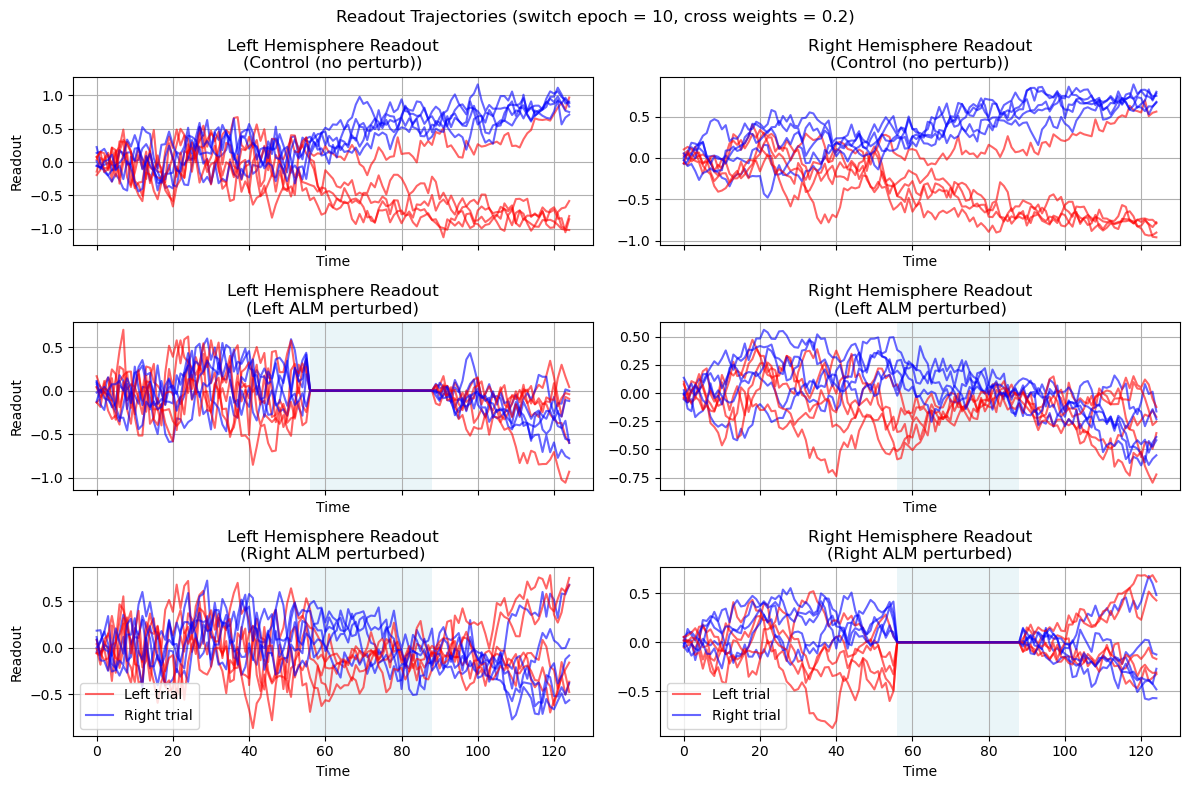

In [28]:
# Plot what happens to individual readouts on control vs perturbation trials
import matplotlib.gridspec as gridspec

# start by loading data
train_save_path = os.path.join(exp.configs['data_dir'], 'train')

train_sensory_inputs = np.load(os.path.join(train_save_path, 'onehot_sensory_inputs.npy' ))
train_trial_type_labels = np.load(os.path.join(train_save_path, 'onehot_trial_type_labels.npy'))
# load train inputs and labels

train_sensory_inputs.shape, train_trial_type_labels.shape

l_trial_idx = np.where(train_trial_type_labels == 0)[0]
r_trial_idx = np.where(train_trial_type_labels == 1)[0]

l_trial_input = train_sensory_inputs[l_trial_idx, :]
r_trial_input = train_sensory_inputs[r_trial_idx, :]

l_trial_input = torch.tensor(l_trial_input).to(device)
r_trial_input = torch.tensor(r_trial_input).to(device)
l_trial_input.shape

sample_begin = exp.sample_begin
delay_begin = exp.delay_begin
l_trial_input_all, r_trial_input_all = l_trial_input, r_trial_input


### After data loading, run model

# Pass input into model
fig, axs = plt.subplots(3, 2, figsize=(12, 8), sharex=True)  # 3 conditions, 2 hemispheres

# Define condition names for labeling
condition_names = [
    "Control (no perturb)", 
    "Left ALM perturbed", 
    "Right ALM perturbed"
]
# For legend management
line_objs = [[None, None] for _ in range(3)]

# For each of the three conditions: control, left alm pert, right alm pert
for rowidx, (uni_pert, left_pert) in enumerate([
        (0.0, 0.5),   # Control: no perturb
        (1.0, 1.0),   # Left ALM perturbed
        (1.0, 0.0)    # Right ALM perturbed
    ]):

    # Set model perturbation parameters for condition
    model.uni_pert_trials_prob = uni_pert
    model.left_alm_pert_prob = left_pert
    hs_l, zs_l = model(l_trial_input_all)    # left trial
    hs_r, zs_r = model(r_trial_input_all)    # right trial

    for i in range(5):
        # l_trial_input = l_trial_input_all[i].reshape(1, exp.T, 2)
        # r_trial_input = r_trial_input_all[i].reshape(1, exp.T, 2)

        # Compute left and right readouts for left and right trials
        left_readout_l = hs_l[i, :, :model.n_neurons//2].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, :model.n_neurons//2]
        )
        right_readout_l = hs_l[i, :, model.n_neurons//2:].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, model.n_neurons//2:]
        )

        left_readout_r = hs_r[i, :, :model.n_neurons//2].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, :model.n_neurons//2]
        )
        right_readout_r = hs_r[i, :, model.n_neurons//2:].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, model.n_neurons//2:]
        )

        # Left hemisphere readout subplot (col 0)
        l_line = axs[rowidx,0].plot(left_readout_l.flatten(), color='red', alpha=0.6, label='Left trial' if i==0 else None)
        r_line = axs[rowidx,0].plot(left_readout_r.flatten(), color='blue', alpha=0.6, label='Right trial' if i==0 else None)
        if i == 0: line_objs[rowidx][0] = (l_line[0], r_line[0])

        # Right hemisphere readout subplot (col 1)
        l_line2 = axs[rowidx,1].plot(right_readout_l.flatten(), color='red', alpha=0.6, label='Left trial' if i==0 else None)
        r_line2 = axs[rowidx,1].plot(right_readout_r.flatten(), color='blue', alpha=0.6, label='Right trial' if i==0 else None)
        if i == 0: line_objs[rowidx][1] = (l_line2[0], r_line2[0])

    # Add light blue bar (span) for perturbation period on perturbation subplots
    # Only add for perturbed conditions (rowidx 1 and 2)
    if rowidx in [1, 2]:
        # perturbation likely in delay epoch; use exp.delay_begin, exp.T for x-range
        axs[rowidx,0].axvspan(exp.delay_begin, exp.pert_end, facecolor='lightblue', alpha=0.25, zorder=0)
        axs[rowidx,1].axvspan(exp.delay_begin, exp.pert_end, facecolor='lightblue', alpha=0.25, zorder=0)

    # Titles, labels for each row
    axs[rowidx,0].set_title(f"Left Hemisphere Readout\n({condition_names[rowidx]})" )
    axs[rowidx,1].set_title(f"Right Hemisphere Readout\n({condition_names[rowidx]})")
    axs[rowidx,0].set_ylabel("Readout")
    axs[rowidx,0].set_xlabel("Time")
    axs[rowidx,1].set_xlabel("Time")
    axs[rowidx,0].grid()
    axs[rowidx,1].grid()

# Only show legend in the bottom row for both hemispheres (col 0/col 1)
for col in range(2):
    axs[-1,col].legend()

plt.suptitle(f'Readout Trajectories (switch epoch = {exp.configs["switch_epoch_n"]}, cross weights = {exp.configs["init_cross_hemi_rel_factor"]})')
plt.tight_layout()
plt.show()




Fixed input weights for left and right ALM


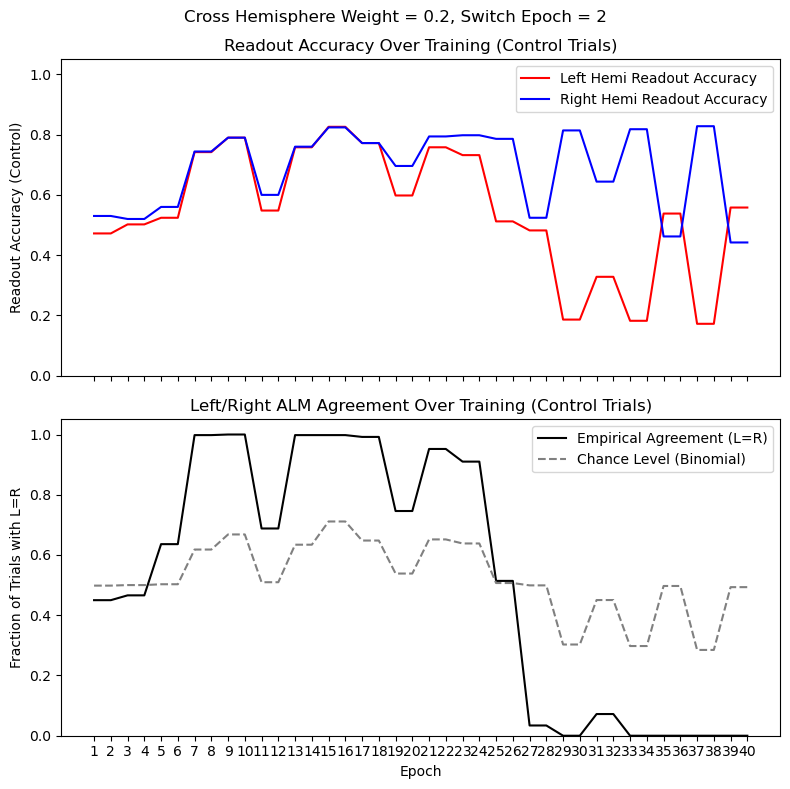

In [32]:
# single learning curve

exp = DualALMRNNExp()

# Load configs to get model parameters
with open('dual_alm_rnn_configs.json', 'r') as f:
    configs = json.load(f)

exp.configs['switch_epoch_n'] = 2
exp.configs['random_seed'] = 2
exp.configs['n_epochs'] = 40
exp.configs['train_type'] = 'train_type_modular_fixed_input_cross_hemi_switch'
exp.configs['init_cross_hemi_rel_factor'] = 0.2



model = getattr(sys.modules[__name__], configs['model_type'])(configs, \
    exp.a, exp.pert_begin, exp.pert_end, noise=True)

exp.init_sub_path(exp.configs['train_type'])
checkpoint_file = 'all_val_results_dict.npy'
checkpoint_path = os.path.join(configs['logs_dir'], configs['model_type'], exp.sub_path, checkpoint_file)

results_dict = np.load(checkpoint_path, allow_pickle=True)

epochs = np.arange(1, len(results_dict) + 1)
readout_acc_left = np.array([results_dict[i]['control']['readout_accuracy_left'] for i in range(len(results_dict))])
readout_acc_right = np.array([results_dict[i]['control']['readout_accuracy_right'] for i in range(len(results_dict))])

# time_to_reach.append(np.where(readout_acc_left > 0.9)[0][0])
# time_to_reach_right.append(np.where(readout_acc_right > 0.9)[0][0])


n_trials_agreed = np.array([results_dict[i]['control']['n_trials_agreed'] for i in range(len(results_dict))])
n_trials = np.array([results_dict[i]['control']['n_trials'] for i in range(len(results_dict))])
agreement_frac = n_trials_agreed / n_trials

# Compute chance level: p(agree) = p_L^2 + (1-p_L)^2 if p_L = p_R, but here use both
chance_agree = readout_acc_left * readout_acc_right + (1 - readout_acc_left) * (1 - readout_acc_right)

corruption_start_epoch = exp.configs['corruption_start_epoch']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Top subplot: Readout accuracies
ax1.plot(epochs, readout_acc_left, color='r', label='Left Hemi Readout Accuracy')
ax1.plot(epochs, readout_acc_right, color='b', label='Right Hemi Readout Accuracy')
if exp.configs['train_type'] == 'train_type_modular_corruption':
    ax1.axvline(corruption_start_epoch, color='r', linestyle=':', linewidth=2, label='Corruption Start (Epoch {})'.format(corruption_start_epoch))
ax1.set_ylabel('Readout Accuracy (Control)')
ax1.set_title('Readout Accuracy Over Training (Control Trials)')
ax1.set_xticks(epochs)
ax1.set_ylim(0, 1.05)
ax1.legend()

# Bottom subplot: Agreement
ax2.plot(epochs, agreement_frac, color='k', label='Empirical Agreement (L=R)')
ax2.plot(epochs, chance_agree, color='gray', linestyle='--', label='Chance Level (Binomial)')
if exp.configs['train_type'] == 'train_type_modular_corruption':
    ax2.axvline(corruption_start_epoch, color='r', linestyle=':', linewidth=2, label='Corruption Start (Epoch {})'.format(corruption_start_epoch))
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Fraction of Trials with L=R')
ax2.set_title('Left/Right ALM Agreement Over Training (Control Trials)')
ax2.set_xticks(epochs)
ax2.set_ylim(0, 1.05)
ax2.legend()
# plt.xlim(0,20) /

plt.suptitle(f'Cross Hemisphere Weight = {exp.configs["init_cross_hemi_rel_factor"]}, Switch Epoch = {exp.configs["switch_epoch_n"]}')

plt.tight_layout()

Fixed input weights for left and right ALM
Fixed input weights for left and right ALM
Fixed input weights for left and right ALM


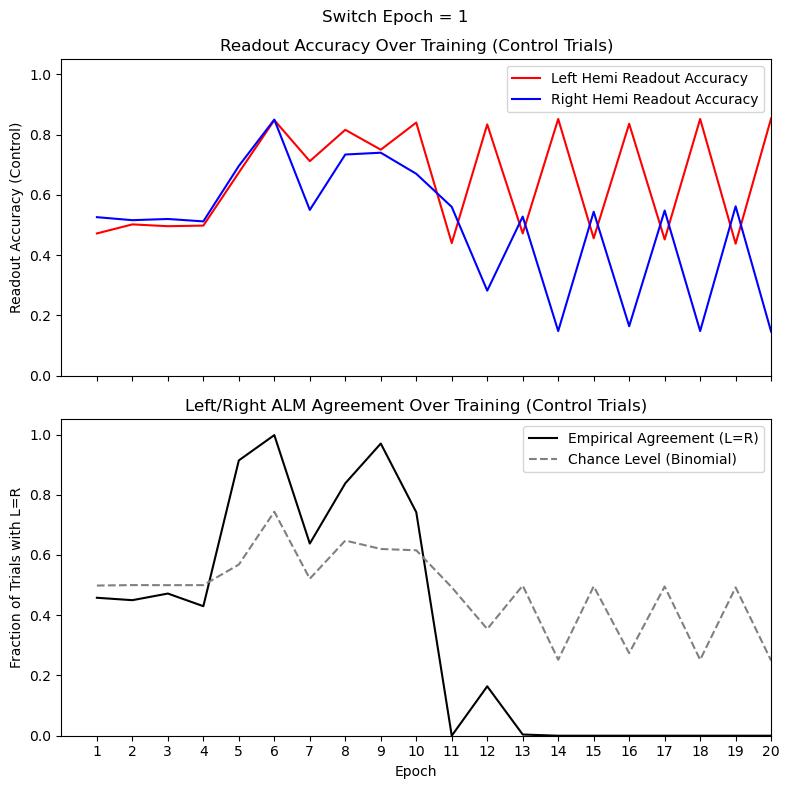

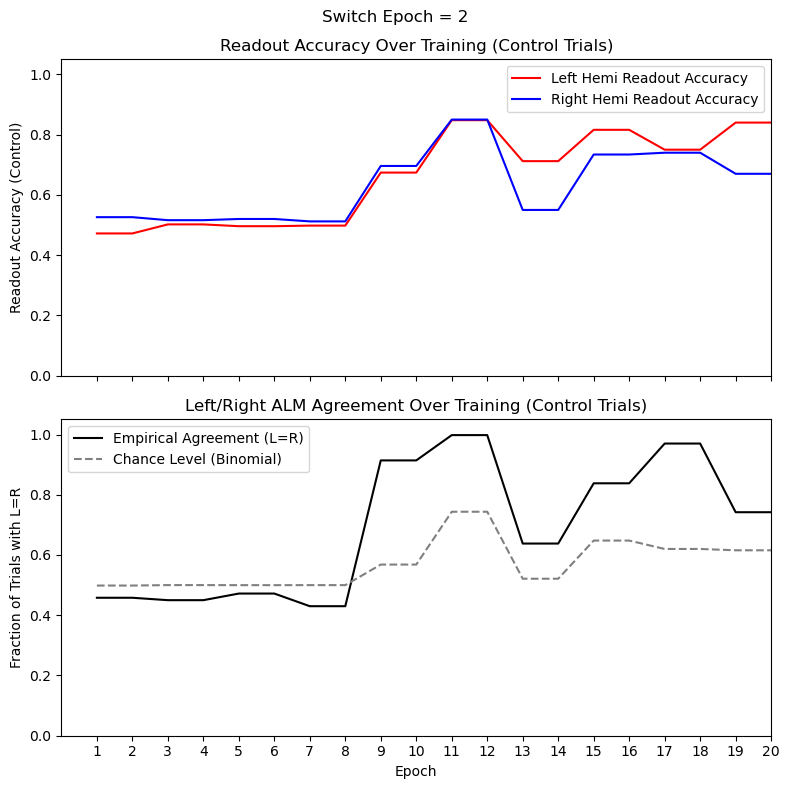

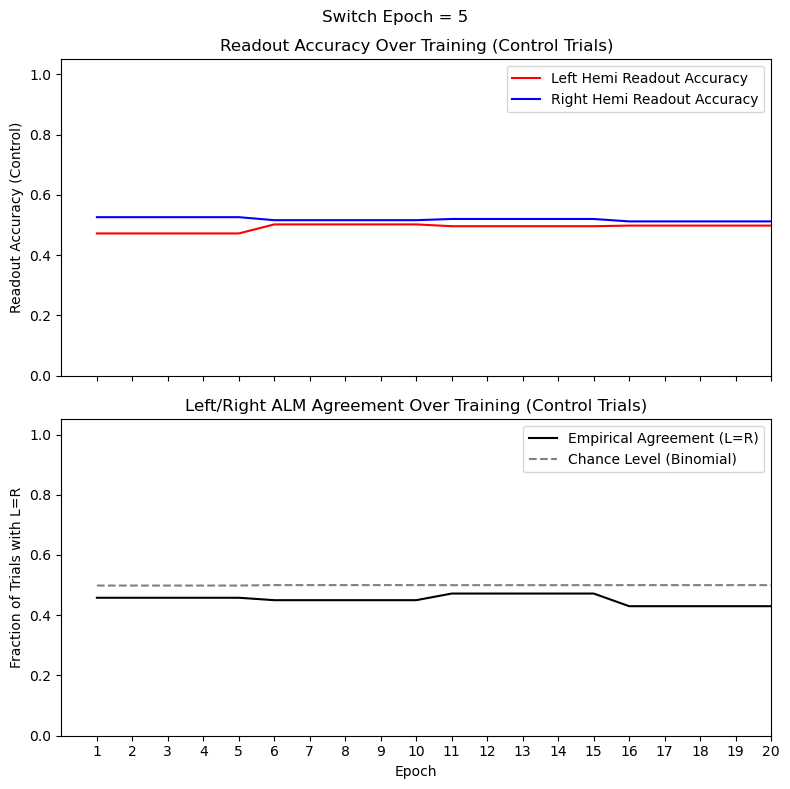

In [18]:
# Make some learning curves

for switch_epoch_n in [1,2, 5]:


    exp = DualALMRNNExp()

    # Load configs to get model parameters
    with open('dual_alm_rnn_configs.json', 'r') as f:
        configs = json.load(f)

    exp.configs['switch_epoch_n'] = switch_epoch_n
    exp.configs['random_seed'] = 2
    exp.configs['n_epochs'] = 20
    exp.configs['train_type'] = 'train_type_modular_fixed_input_cross_hemi_switch'
    exp.configs['init_cross_hemi_rel_factor'] = 0.001

    

    model = getattr(sys.modules[__name__], configs['model_type'])(configs, \
        exp.a, exp.pert_begin, exp.pert_end, noise=True)

    exp.init_sub_path(exp.configs['train_type'])
    checkpoint_file = 'all_val_results_dict.npy'
    checkpoint_path = os.path.join(configs['logs_dir'], configs['model_type'], exp.sub_path, checkpoint_file)

    results_dict = np.load(checkpoint_path, allow_pickle=True)

    epochs = np.arange(1, len(results_dict) + 1)
    readout_acc_left = np.array([results_dict[i]['control']['readout_accuracy_left'] for i in range(len(results_dict))])
    readout_acc_right = np.array([results_dict[i]['control']['readout_accuracy_right'] for i in range(len(results_dict))])

    # time_to_reach.append(np.where(readout_acc_left > 0.9)[0][0])
    # time_to_reach_right.append(np.where(readout_acc_right > 0.9)[0][0])


    n_trials_agreed = np.array([results_dict[i]['control']['n_trials_agreed'] for i in range(len(results_dict))])
    n_trials = np.array([results_dict[i]['control']['n_trials'] for i in range(len(results_dict))])
    agreement_frac = n_trials_agreed / n_trials

    # Compute chance level: p(agree) = p_L^2 + (1-p_L)^2 if p_L = p_R, but here use both
    chance_agree = readout_acc_left * readout_acc_right + (1 - readout_acc_left) * (1 - readout_acc_right)

    corruption_start_epoch = exp.configs['corruption_start_epoch']

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # Top subplot: Readout accuracies
    ax1.plot(epochs, readout_acc_left, color='r', label='Left Hemi Readout Accuracy')
    ax1.plot(epochs, readout_acc_right, color='b', label='Right Hemi Readout Accuracy')
    if exp.configs['train_type'] == 'train_type_modular_corruption':
        ax1.axvline(corruption_start_epoch, color='r', linestyle=':', linewidth=2, label='Corruption Start (Epoch {})'.format(corruption_start_epoch))
    ax1.set_ylabel('Readout Accuracy (Control)')
    ax1.set_title('Readout Accuracy Over Training (Control Trials)')
    ax1.set_xticks(epochs)
    ax1.set_ylim(0, 1.05)
    ax1.legend()

    # Bottom subplot: Agreement
    ax2.plot(epochs, agreement_frac, color='k', label='Empirical Agreement (L=R)')
    ax2.plot(epochs, chance_agree, color='gray', linestyle='--', label='Chance Level (Binomial)')
    if exp.configs['train_type'] == 'train_type_modular_corruption':
        ax2.axvline(corruption_start_epoch, color='r', linestyle=':', linewidth=2, label='Corruption Start (Epoch {})'.format(corruption_start_epoch))
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Fraction of Trials with L=R')
    ax2.set_title('Left/Right ALM Agreement Over Training (Control Trials)')
    ax2.set_xticks(epochs)
    ax2.set_ylim(0, 1.05)
    ax2.legend()
    plt.xlim(0,20)

    plt.suptitle(f'Switch Epoch = {switch_epoch_n}')

    plt.tight_layout()